In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:

emotions= np.array(['ang', 'exc', 'neu', 'sad'])
data_path = "/content/drive/MyDrive/"


In [3]:
import pickle
with open('/home/ec22046/features.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [4]:
x_train_speech = np.load('/home/ec22046/speech.npy')
print(x_train_speech.shape)

(4936, 100, 34)


### Text Preprocessing

In [5]:
# !wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_
import re

2023-08-23 13:12:48.587625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 13:12:52.372667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec22046/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def preproc(df, colname):
  df[colname] = df[colname].apply(func=clean_html)
  df[colname] = df[colname].apply(func=remove_links)
  df[colname] = df[colname].apply(func=non_ascii)
  df[colname] = df[colname].apply(func=lower)
  df[colname] = df[colname].apply(func=email_address)
  # df[colname] = df[colname].apply(func=removeStopWords)
  df[colname] = df[colname].apply(func=punct)
  df[colname] = df[colname].apply(func=remove_)
  return(df)

In [7]:
X = data2['text']
Y = data2['label']
df = pd.DataFrame(list(zip(X, Y)), columns = ['Text','Labels'])

In [8]:
df_clean = preproc(df, 'Text')
df_clean['num_words'] = df_clean['Text'].apply(lambda x: len(x.split()))

df_clean['Labels'] = pd.Categorical(df_clean['Labels'])
df_clean['Labels'] = df_clean['Labels'].cat.codes

In [9]:
train_size = int(0.8 * len(df['Text']))
test_size = len(df['Text'])-train_size
print(train_size,test_size)

3948 988


In [10]:
x_train_speech_input = x_train_speech[:train_size,:,:]
x_text = np.load('/home/ec22046/text_feature.npy')
Y_train = df_clean['Labels'].loc[:train_size-1]

In [11]:
x_train_speech_input.shape,x_text.shape,Y_train.shape

((3948, 100, 34), (3948, 128), (3948,))

In [12]:
x_test_speech_input = x_train_speech[train_size:,:,:]
x_text_test = np.load('/home/ec22046/text_feature_test.npy')
Y_test = df_clean['Labels'].loc[train_size:]

In [13]:
x_test_speech_input.shape,x_text_test.shape,Y_test.shape

((988, 100, 34), (988, 128), (988,))

In [14]:
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense,Flatten,Bidirectional,LSTM


In [15]:
from keras_nlp.layers import TransformerEncoder
encoder = TransformerEncoder(intermediate_dim=64, num_heads=8,dropout=0.3)
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Using TensorFlow backend
Num GPUs Available:  4


In [16]:
layer_vanilla = tf.keras.layers.Attention()

In [ ]:
text_input = Input(shape=(128))

speech_input = Input(shape=(100,34))
# model_speech1 = Flatten()(speech_input)
# model_speech2 = Dense(1024, activation='relu')(model_speech1)
# model_speech3 = Dense(512, activation='relu')(model_speech2)
# out_speech = Dense(128, activation='relu')(model_speech3)
l1 = Bidirectional(LSTM(256, return_sequences=True), input_shape=(100, 34))(speech_input)
l2 = layer_vanilla([l1,l1])
l3 = Flatten()(l2)
l4 = Dense(512, activation='relu')(l3)
out_speech = Dense(128, activation='relu')(l4)


encoder_input  = tf.keras.layers.Concatenate()([text_input,out_speech])
encoder_input = tf.keras.layers.Reshape((2,128))(encoder_input)
output_t = encoder(encoder_input)
output_t = tf.keras.layers.Reshape((1,256))(output_t)

current_shape = output_t.shape.as_list()

new_shape = (-1, current_shape[-1])
output_t = tf.reshape(output_t, new_shape)

model_combined2 = Dense(128, activation='relu')(output_t)
model_combined3 = Dense(4, activation='softmax')(model_combined2)

# model compile
model_combined = tf.keras.Model([text_input, speech_input], model_combined3)
model_combined.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_combined.summary()

2023-08-11 17:32:13.249196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:02:00.0, compute capability: 7.5
2023-08-11 17:32:13.251509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:04:00.0, compute capability: 7.5
2023-08-11 17:32:13.252420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 181 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:83:00.0, compute capability: 7.5
2023-08-11 17:32:13.253033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 6644 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 2070, pci

: 

: 

In [21]:
history = model_combined.fit(
    x = [x_text,x_train_speech_input],
    y = to_categorical(Y_train),
    validation_data = ([x_text_test,x_test_speech_input],
                        to_categorical(Y_test)),
    epochs=25,
    batch_size=32
)

Epoch 1/25


2023-08-11 17:32:21.579787: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1620 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 5386010624 bandwidth: 448064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-08-11 17:32:23.059583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-11 17:32:24.568644: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1140093ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices

124/124 [==============================] - ETA: 0s - loss: 0.2375 - acc: 0.9222

2023-08-11 17:32:31.979159: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1620 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 5386010624 bandwidth: 448064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


124/124 [==============================] - 15s 29ms/step - loss: 0.2375 - acc: 0.9222 - val_loss: 1.4384 - val_acc: 0.6913
Epoch 2/25
124/124 [==============================] - 3s 22ms/step - loss: 0.1532 - acc: 0.9443 - val_loss: 1.6136 - val_acc: 0.6609
Epoch 3/25
124/124 [==============================] - 3s 22ms/step - loss: 0.1529 - acc: 0.9433 - val_loss: 1.4425 - val_acc: 0.6903
Epoch 4/25
124/124 [==============================] - 3s 22ms/step - loss: 0.1417 - acc: 0.9491 - val_loss: 1.4255 - val_acc: 0.6761
Epoch 5/25
124/124 [==============================] - 3s 22ms/step - loss: 0.1492 - acc: 0.9443 - val_loss: 1.4787 - val_acc: 0.7045
Epoch 6/25
124/124 [==============================] - 3s 22ms/step - loss: 0.1338 - acc: 0.9476 - val_loss: 1.4241 - val_acc: 0.6832
Epoch 7/25
124/124 [==============================] - 3s 22ms/step - loss: 0.1378 - acc: 0.9476 - val_loss: 1.5901 - val_acc: 0.6862
Epoch 8/25
124/124 [==============================] - 3s 22ms/step - loss: 0.14

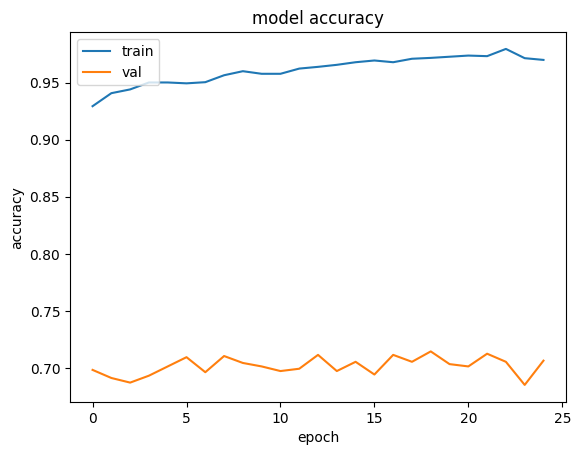

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
data2['speech']

[array([-165, -163, -125, ..., -104, -137, -146], dtype=int16),
 array([-31, -23, -18, ..., -42, -27, -12], dtype=int16),
 array([-12,  -5,  14, ...,  -6,  29,  41], dtype=int16),
 array([-28, -41, -55, ...,  90,  77,  57], dtype=int16),
 array([452, 387, 229, ..., -20, -13,  -6], dtype=int16),
 array([  126,    87,    70, ..., -1353, -2006, -2316], dtype=int16),
 array([ 83,  92,  98, ..., 276, 340, 462], dtype=int16),
 array([ 592,  907, 1027, ...,  -40,  -77,  -83], dtype=int16),
 array([ 24,  16,  20, ...,  72,  89, 100], dtype=int16),
 array([-53, -54, -64, ..., -51, -46, -50], dtype=int16),
 array([116, 108,  93, ..., -55, -78, -90], dtype=int16),
 array([-57, -53, -50, ..., -97, -79, -54], dtype=int16),
 array([ 74,  78,  67, ...,   7, -11,  -1], dtype=int16),
 array([ -34,  -35,  -62, ..., -148, -150, -153], dtype=int16),
 array([148, 133, 105, ...,  76,  80,  91], dtype=int16),
 array([ -36,   -8,   26, ...,  -56,  -85, -105], dtype=int16),
 array([-25, -21, -10, ...,  -4,  14